# Iceberg Classifier Challenge


## Introduction

This project will predict whether an image contains a ship or an iceberg with machine learning.

## Load Modules

In [74]:
# Data Manipulation
import pandas as pd
pd.options.display.max_columns = 25
import numpy as np
from IPython.display import display

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid", {"axes.grid": False})
import missingno as msno

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, log_loss
#from xgboost import XGBClassifier

## Load Data

In [105]:
# test, train and submission files
test = pd.read_json('data/test.json')
test_df = pd.DataFrame(test)

train = pd.read_json('data/train.json')
train_df = pd.DataFrame(train)

submission_ex = pd.read_csv('data/sample_submission.csv')

## Data Structure

### Basic Structure

shape
info
describe

In [4]:
train_df.shape

(1604, 5)

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1604 entries, 0 to 1603
Data columns (total 5 columns):
band_1        1604 non-null object
band_2        1604 non-null object
id            1604 non-null object
inc_angle     1604 non-null object
is_iceberg    1604 non-null int64
dtypes: int64(1), object(4)
memory usage: 75.2+ KB


In [6]:
train_df.describe()

,is_iceberg
count,1604.000000
mean,0.469451
std,0.499222
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [7]:
train_df.head()

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878361, -27.15416, -28.668615, -29.537971...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920305, -14.920363, -12.66633...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


Looks like pandas read the inc_angle as text. We'll have to convert that to a float.

In [115]:
train_df.replace('na', np.NaN, inplace=True)
train_df['inc_angle'] = pd.to_numeric(train_df['inc_angle'])
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1604 entries, 0 to 1603
Data columns (total 5 columns):
band_1        1604 non-null object
band_2        1604 non-null object
id            1604 non-null object
inc_angle     1471 non-null float64
is_iceberg    1604 non-null int64
dtypes: float64(1), int64(1), object(3)
memory usage: 75.2+ KB


### Missing Data

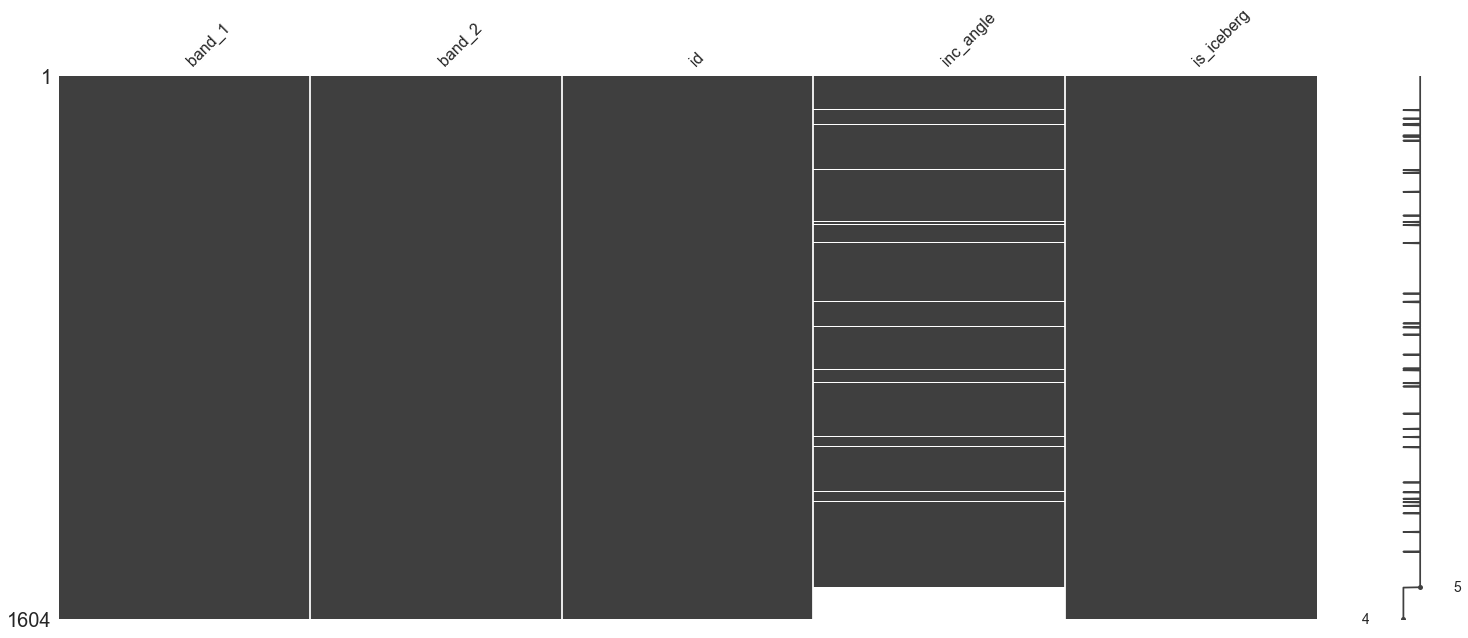

In [9]:
msno.matrix(train_df)

## Visualizations

Plot a sample image and an 8 by 8 array of samples

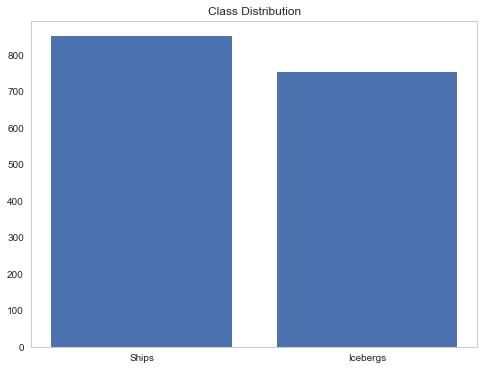

In [10]:
val_counts = train_df.is_iceberg.value_counts()
plt.figure(figsize=(8,6))
plt.bar(
    val_counts.index,
    val_counts.values
)
plt.xticks(range(2), ['Ships', 'Icebergs'])
plt.title('Class Distribution')
plt.show()

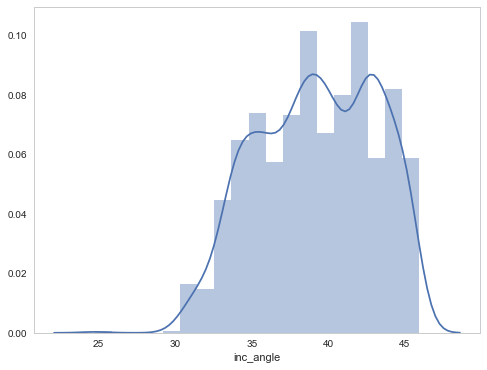

In [11]:
val_counts = train_df.inc_angle.value_counts()
plt.figure(figsize=(8,6))
sns.distplot(
    train_df.inc_angle.dropna()
)
plt.show()

In [12]:
band_1_ex = train_df.loc[0, 'band_1']
band_1_ex = np.array(band_1_ex)
band_1_square = band_1_ex.reshape(75, 75)

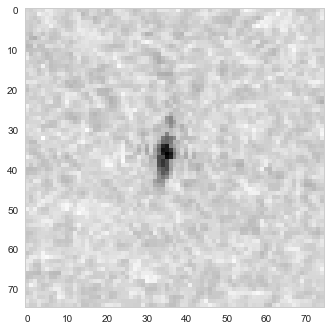

In [13]:
plt.imshow(band_1_square)
plt.show()

In [14]:
band_2_ex = train_df.loc[0, 'band_2']
band_2_ex = np.array(band_2_ex)
band_2_square = band_2_ex.reshape(75, 75)

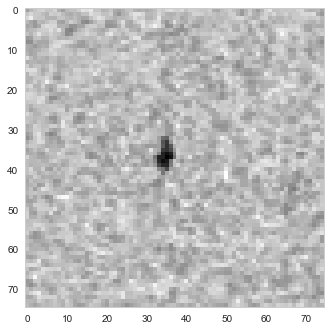

In [15]:
plt.imshow(band_2_square)
plt.show()

In [16]:
band_1_ex = train_df.loc[0, 'band_1']
band_2_ex = train_df.loc[0, 'band_2']
band_sub_1 = np.array(band_1_ex)
band_sub_2 = np.array(band_2_ex)
band_sub = band_sub_1 - band_sub_2
band_sub_square = band_sub.reshape(75, 75)

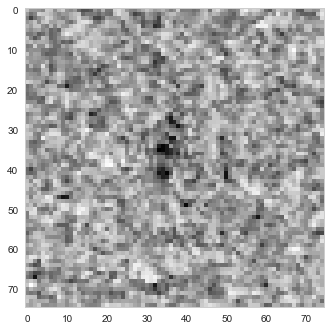

In [17]:
plt.imshow(band_sub_square)
plt.show()

In the example pics, the contrast between the hh and hv iceberg images is greater than the contrast between the hh and hv ship images. Icebergs seem to "disappear" under hv images, while ships are clearly visible in both hv and hh images. That difference in contrast may be the key.

In [42]:
def plot_image_grid(train, band_type, n_row, n_col):
    band = 'band_1'
    if 'HV' in band_type:
        band = 'band_2'
    classification = ''
    # Plot the first 8 eignenvalues
    plt.figure(figsize=(12,12))
    for i in list(range(n_row * n_col)):
    #     for offset in [10, 30,0]:
    #     plt.subplot(n_row, n_col, i + 1)
    #     offset =0
        sat_image = train.loc[i, band]
        sat_image = np.array(sat_image)
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(sat_image.reshape(75,75))
        
        if train.loc[i, 'is_iceberg']:
            classification = 'Iceberg'
        else:
            classification = 'Ship'
        title_text = "{0} {1:.0f} {2}".format(classification, train.loc[i, 'inc_angle'], '$^\circ$')
        plt.title(title_text, size=6.5)
        plt.xticks(())
        plt.yticks(())
    plt.suptitle(band_type)
    plt.show()


Plot ships and icebergs separately. Show ship hh and hv images, then iceberg hh and hv images to get a better feel for their differences.

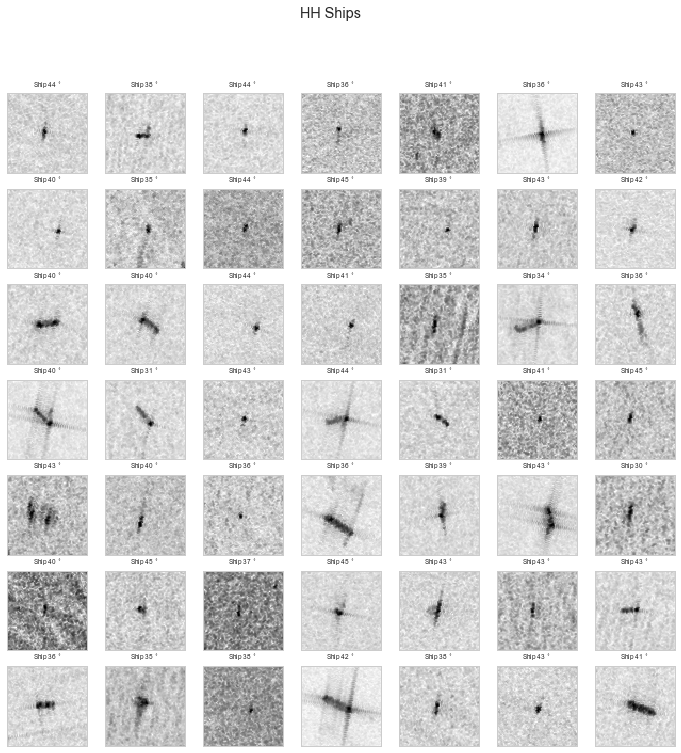

In [43]:
plot_image_grid(
    train_df[train_df.is_iceberg==0].reset_index(drop=True), 
    'HH Ships', 
    7, 
    7
)

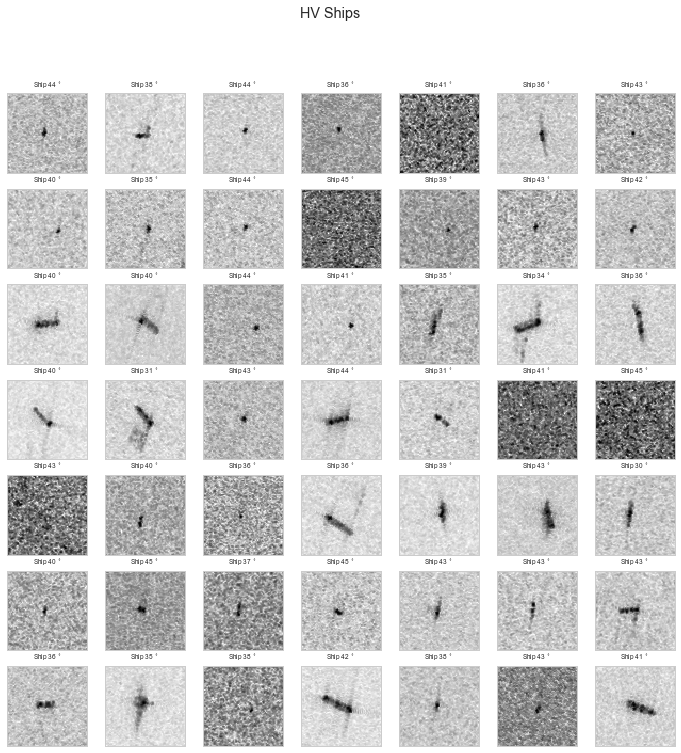

In [44]:
plot_image_grid(
    train_df[train_df.is_iceberg==0].reset_index(drop=True), 
    'HV Ships', 
    7, 
    7
)

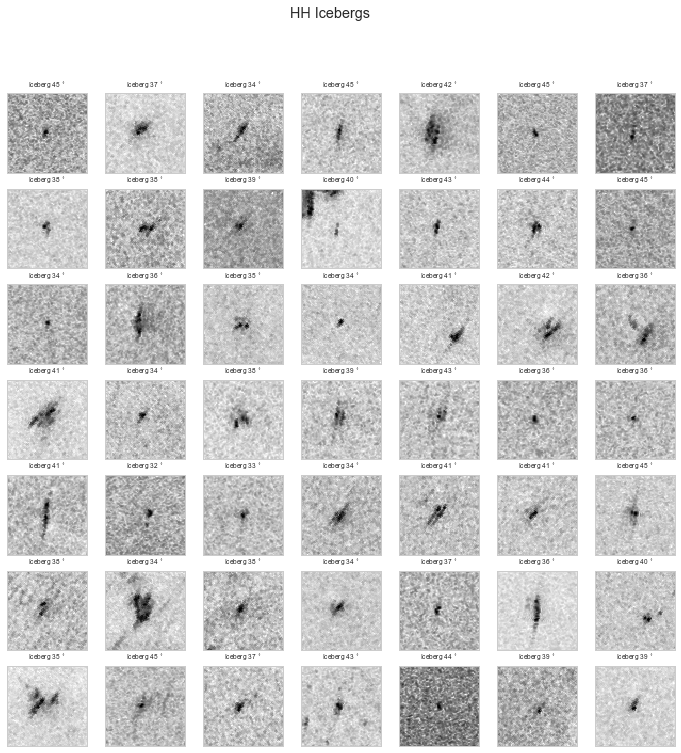

In [45]:
plot_image_grid(
    train_df[train_df.is_iceberg==1].reset_index(drop=True), 
    'HH Icebergs', 
    7, 
    7
)

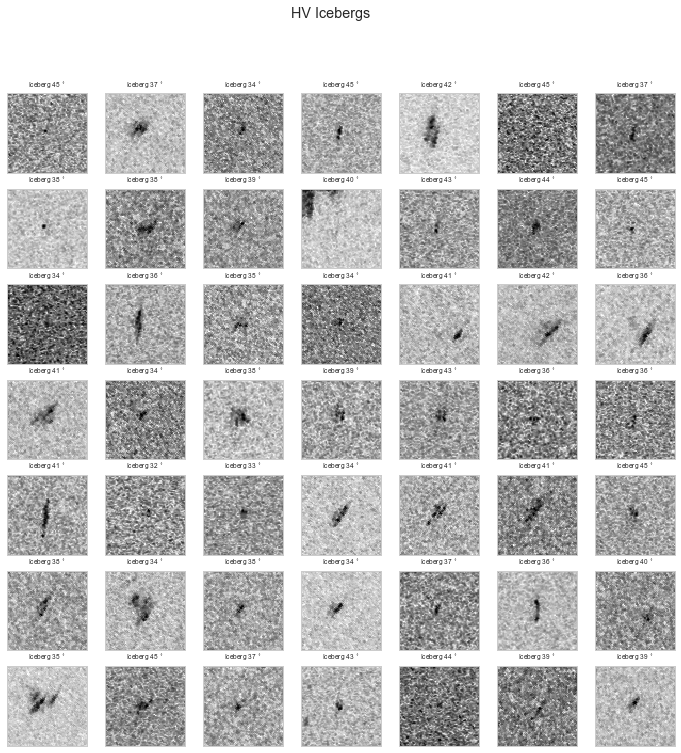

In [46]:
plot_image_grid(
    train_df[train_df.is_iceberg==1].reset_index(drop=True), 
    'HV Icebergs', 
    7, 
    7
)

## Feature Engineering

Need a way to feed the data from the two images into the classifier.

First thought:
Subtract the two arrays and use the incidence angle as just another column.

- Turn each band cell into a numpy array
- The whole column can be a higher dimensional array
- Subtract the two arrays
- Turn the inc_angle column into a numpy array
- Concatenate the difference and inc_angle columns
- Feed into algorithm

Other ideas:
1. Combine the two images
2. Extract the highest and lowest values from each hh and hv image
3. Use PCA for dimensionality reduction
4. Use fisher images for dimensionality reduction
5. Reduce noise in darker images
6. Compare HH images only
7. Take average of both images

In [109]:
band_1_arr = train_df.band_1.apply(np.asarray)
band_2_arr = train_df.band_2.apply(np.asarray)
band_diff = band_1_arr - band_2_arr
band_ave = (band_1_arr + band_2_arr)/2.0

band_ave_series = band_ave.apply(pd.Series)
band_diff_series = band_diff.apply(pd.Series)
band_1_df = band_1_arr.apply(pd.Series)
band_2_df = band_2_arr.apply(pd.Series)

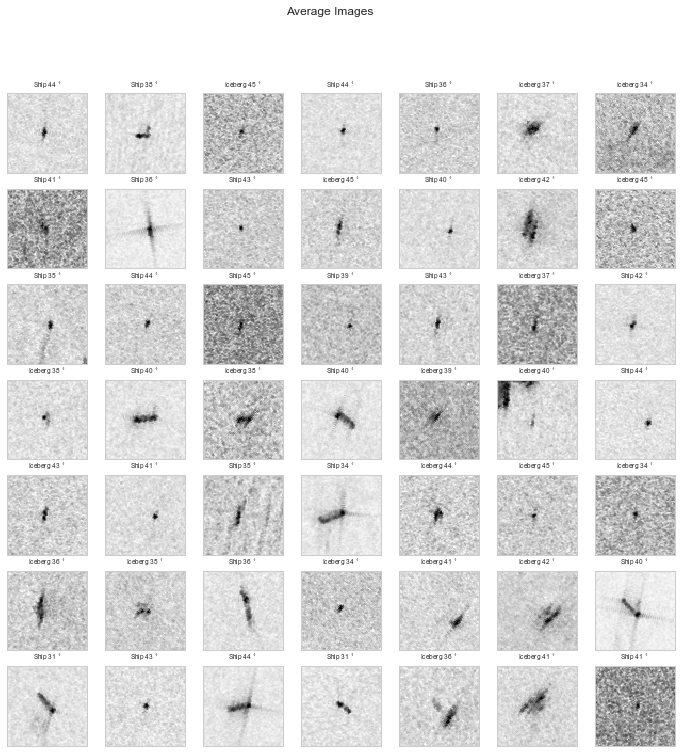

In [113]:
band_ave_df = train_df.copy()
band_ave_df.band_1 = band_ave
plot_image_grid(band_ave_df, 'Average Images', 7, 7)

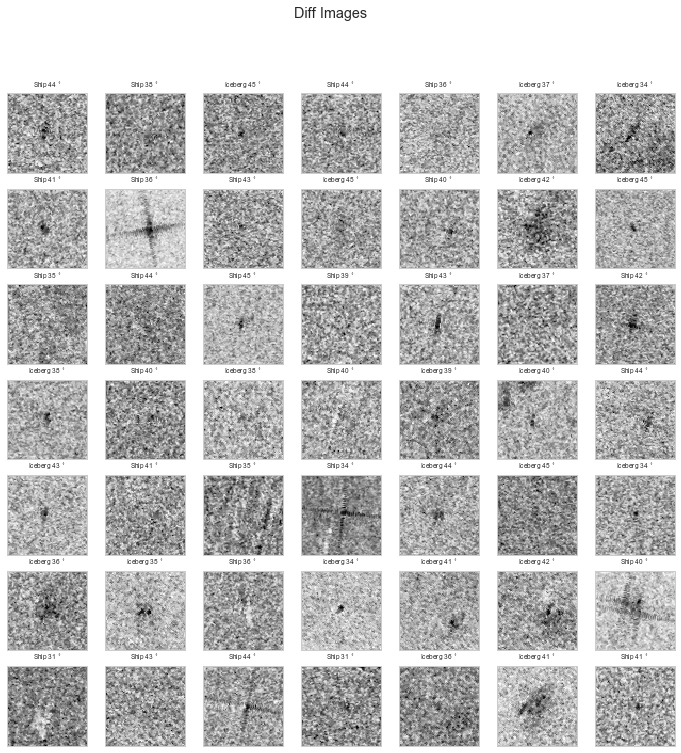

In [50]:
band_diff_df = train_df.copy()
band_diff_df.band_1 = band_diff
plot_image_grid(band_diff_df, 'Diff Images', 7, 7)

Second thought: Turn the images into 3d arrays

## Dimensionality Reduction

Need to explore digit recognition notebooks on:
- PCA
- The other two

What increases accuracy from 94% to 99.9%?

## Models

- Randomforest
- XGboost
- Research!

- split into x and y
- split into train and test
- fit
- test
- measure accuracy
  - Accuracy score
  - Confusion matrix
  - 

### HH Models

#### Random Forests

In [80]:
hh_idea = pd.concat((band_1_df, train_df.inc_angle), axis=1)
forest = RandomForestClassifier(random_state=42)

x = hh_idea[hh_idea.inc_angle.isnull()==False].values
y = train_df.loc[train_df.inc_angle.isnull()==False, 'is_iceberg'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, random_state=42)
forest.fit(x_train, y_train)
pred = forest.predict(x_test)
pred_prob = forest.predict_proba(x_test)
print "Log Loss:", log_loss(y_test, pred_prob, eps=1e-15)
print "Accuracy Score:", accuracy_score(y_test, pred)
print "Classification Report"
print classification_report(y_test, pred)
hh_conf_matrix = confusion_matrix(y_test, pred)

Log Loss: 0.636701384187
Accuracy Score: 0.717194570136
Classification Report
             precision    recall  f1-score   support

          0       0.69      0.75      0.72       211
          1       0.75      0.69      0.72       231

avg / total       0.72      0.72      0.72       442



#### Logistic Regression

In [73]:
hh_idea = pd.concat((band_1_df, train_df.inc_angle), axis=1)
logreg = LogisticRegression(random_state=42)

x = hh_idea[hh_idea.inc_angle.isnull()==False].values
y = train_df.loc[train_df.inc_angle.isnull()==False, 'is_iceberg'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, random_state=42)
logreg.fit(x_train, y_train)
pred = logreg.predict(x_test)
print "Accuracy Score:", accuracy_score(y_test, pred)
print "Classification Report"
print classification_report(y_test, pred)
hh_conf_matrix = confusion_matrix(y_test, pred)

Accuracy Score: 0.690045248869
Classification Report
             precision    recall  f1-score   support

          0       0.69      0.63      0.66       211
          1       0.69      0.75      0.72       231

avg / total       0.69      0.69      0.69       442



### HV Model

In [65]:
hv_idea = pd.concat((band_2_df, train_df.inc_angle), axis=1)
forest = RandomForestClassifier(random_state=42)

x = hv_idea[hv_idea.inc_angle.isnull()==False].values
y = train_df.loc[train_df.inc_angle.isnull()==False, 'is_iceberg'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, random_state=42)
forest.fit(x_train, y_train)
pred = forest.predict(x_test)
print "Classification Report"
print classification_report(y_test, pred)
hv_conf_matrix = confusion_matrix(y_test, pred)

Classification Report
             precision    recall  f1-score   support

          0       0.65      0.71      0.68       211
          1       0.71      0.65      0.68       231

avg / total       0.68      0.68      0.68       442



### Difference Model

In [120]:
first_idea = pd.concat((band_diff_series, train_df.inc_angle), axis=1)
forest = RandomForestClassifier(random_state=42)

x = first_idea[first_idea.inc_angle.isnull()==False].values
y = train_df.loc[train_df.inc_angle.isnull()==False, 'is_iceberg'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, random_state=42)
forest.fit(x_train, y_train)
pred = forest.predict(x_test)
print "Classification Report"
print classification_report(y_test, pred)
diff_conf_matrix = confusion_matrix(y_test, pred)

Classification Report
             precision    recall  f1-score   support

          0       0.59      0.70      0.64       211
          1       0.67      0.55      0.61       231

avg / total       0.63      0.62      0.62       442



### Average Model

In [122]:
average_idea = pd.concat((band_ave_series, train_df.inc_angle), axis=1)
forest = RandomForestClassifier(random_state=42)

x = average_idea[average_idea.inc_angle.isnull()==False].values
y = train_df.loc[train_df.inc_angle.isnull()==False, 'is_iceberg'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, random_state=42)
forest.fit(x_train, y_train)
pred = forest.predict(x_test)
pred_prob = forest.predict_proba(x_test)
print "Log Loss:", log_loss(y_test, pred_prob, eps=1e-15)
print "Accuracy Score:", accuracy_score(y_test, pred)
print "Classification Report"
print classification_report(y_test, pred)
ave_conf_matrix = confusion_matrix(y_test, pred)

Log Loss: 0.659247172182
Accuracy Score: 0.753393665158
Classification Report
             precision    recall  f1-score   support

          0       0.71      0.82      0.76       211
          1       0.81      0.70      0.75       231

avg / total       0.76      0.75      0.75       442



In [67]:
def plot_conf_matrix(conf_matrix, title):
    conf_df = pd.DataFrame(conf_matrix)
    conf_df.columns = ['Ship', 'Iceberg']
    conf_df.index = ['Ship', 'Iceberg']
    
    sns.heatmap(
        conf_df,
        square=True,
        annot=True,
        cmap='viridis',
        fmt='0g'
    )
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.suptitle(title)
    plt.show()

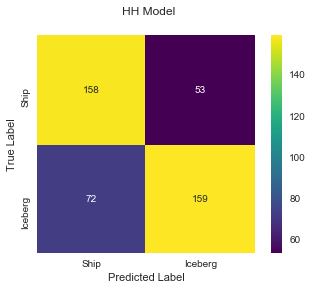

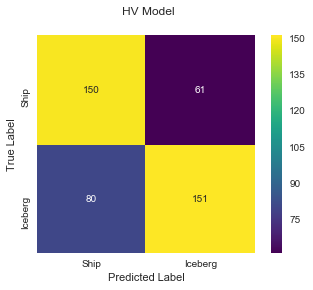

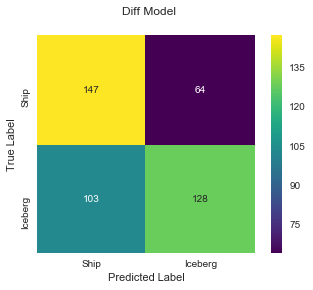

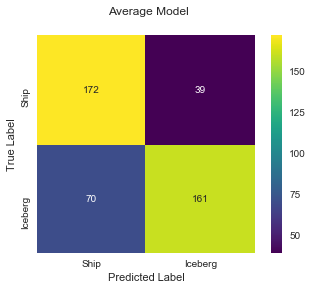

In [121]:
plot_conf_matrix(hh_conf_matrix, 'HH Model')
plot_conf_matrix(hv_conf_matrix, 'HV Model')
plot_conf_matrix(diff_conf_matrix, 'Diff Model')
plot_conf_matrix(ave_conf_matrix, 'Average Model')

## Submission 1 (HH Only)

You want the second column from the pred_prob array. That turns into the is_iceberg column. Also need to keep track of the ids.

Convert band_1 to its own dataframe

In [87]:
band_1_test_arr = test_df.band_1.apply(np.asarray)
band_1_test_df = band_1_test_arr.apply(pd.Series)

Extract inc_angle from test set and concat with band_1

In [90]:
hh_submission = pd.concat((band_1_test_df, test_df.inc_angle), axis=1)

Run predict_proba on array

In [ ]:
x = hh_submission.values
pred = forest.predict(x)
pred_prob = forest.predict_proba(x)

Convert pred_prob to dataframe for submission

In [100]:
submission = pd.DataFrame(pred_prob)
submission.columns = ['not_iceberg', 'is_iceberg']

Extract the right column from each predict_proba row

In [102]:
submission = submission.is_iceberg
submission = pd.concat((test_df.id, submission), axis=1)

Check to make sure dataframe is formatted correctly

In [103]:
submission.head()

,id,is_iceberg
0,5941774d,0.5
1,4023181e,0.3
2,b20200e4,0.8
3,e7f018bb,0.5
4,4371c8c3,0.7


Convert to csv for submission

In [108]:
submission.to_csv('data/submission_v1.csv', index=False)

## Sandbox

In [70]:
submission.shape

(8424, 2)

In [71]:
submission.head()

,id,is_iceberg
0,5941774d,0.5
1,4023181e,0.5
2,b20200e4,0.5
3,e7f018bb,0.5
4,4371c8c3,0.5


In [54]:
a = np.array([[[0,1,2]]])
b = np.array([[[3,4,5]]])


In [ ]:
np.concatenate((a,b), axis=2)

In [ ]:
np.concatenate((a,b), axis=2).shape

In [ ]:
np.concatenate((a,b), axis=1)

In [ ]:
np.concatenate((a,b), axis=1).shape

In [ ]:
np.concatenate((a,b), axis=0)

In [ ]:
np.concatenate((a,b), axis=0).shape

In [ ]:
c = np.array([[0,1,2]])
d = np.array([[3,4,5]])

In [ ]:
np.concatenate((c,d), axis=1)

In [ ]:
np.concatenate((c,d), axis=1).shape

In [ ]:
np.concatenate((c,d), axis=0)

In [ ]:
np.concatenate((c,d), axis=0).shape